## Setup database connectivity

In [61]:
%run 'database_connectivity_setup.ipynb'

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `database_connectivity_setup.ipynb` notebook, use that connection object where needed.

#### Import the Necessary Python Packages

In [2]:
%matplotlib inline
import cv2
import numpy as np
import urllib2
import StringIO
from matplotlib import pyplot as plt
from array import array

#### Create cbirapp schema

In [4]:
sql = """create schema cbirapp""";
psql.execute(sql,conn)
conn.commit()

#### Create Greenplum external tables using gpfdist to load data from the training and testing image data files persisted as key-value pairs in a text file, where key is image name and value is image bytes (unsigned char). The gpfdist listener needs to be running on the server. The listener can be started as follows: 
```

gpfdist -d /data/stage/gautam/CBIRImages/ -p 8088 -V -m 255000000

    -d: path on the server where the image csv files are stored, 
    -p: port number on which the listener is listening, 
    -V: verbose, 
    -m: max size of each row (upper limit of 256 MB)

```
#### The key and value are tab separated. 

In [5]:
sql = """drop external table if exists cbirapp.training_images_ext;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create external table cbirapp.training_images_ext (
        img_name varchar,
        img varchar
    )
    LOCATION('gpfdist://mdw:8088/trainingimages.csv')
    FORMAT 'TEXT' (DELIMITER AS E'\t');
"""
psql.execute(sql,conn)
conn.commit()

In [5]:
sql = """select count(*) from cbirapp.training_images_ext"""
psql.read_sql(sql,conn)
# Should ouput 907 images

,count
0,907


In [7]:
# Create the testing external table
sql = """drop external table if exists cbirapp.testing_images_ext;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create external table cbirapp.testing_images_ext (
        img_name varchar,
        img varchar
    )
    LOCATION('gpfdist://mdw:8088/testingimages.csv')
    FORMAT 'TEXT' (DELIMITER AS E'\t');
"""
psql.execute(sql,conn)
conn.commit()

In [6]:
sql = """select count(*) from cbirapp.testing_images_ext"""
psql.read_sql(sql,conn)
# Should output 113 images

,count
0,113


#### Create the internal tables

In [9]:
# Create the training internal table
sql = """drop table if exists cbirapp.training_images;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.training_images AS
        (select * from cbirapp.training_images_ext)
    distributed by (img_name)
"""
psql.execute(sql,conn)
conn.commit()

In [3]:
sql = """select count(*) from cbirapp.training_images"""
psql.read_sql(sql,conn)
# Should ouput 907 images

,count
0,907


In [11]:
# Create the testing internal table
sql = """drop table if exists cbirapp.testing_images;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.testing_images AS
        (select * from cbirapp.testing_images_ext)
    distributed by (img_name)
"""
psql.execute(sql,conn)
conn.commit()

In [4]:
sql = """select count(*) from cbirapp.testing_images"""
psql.read_sql(sql,conn)
# Should ouput 113 images

,count
0,113


### Now we are ready to build the content based image retrieval pipeline, which comprises of the following steps:

``` 
1. First, we build a bag of words representation for our images. This comprises of the following steps:
    a. Compute Root SIFT descriptors for the training and testing images
    b. Perform a k-means clustering of all the Root SIFT descriptors from the 
    training images to form a vocabulary of k words
    c. Assign each Root SIFT descriptor in every image (training and testing) to 
    one of the k-centroids (words) and build a visual word histogram 
    (bag of words representation)
    
2. Next, we will run a Latent Dirichlet Allocation alogrithm to estimate latent topics 
that pervade the collection of images in the training database.
    
3. Given a query (test) image, we estimate the latent topics given the trained 
topic model and the visual word histogram (data).
    
4. We compute the cosine similarity between the estimated topics of the query image 
and all the training images and retrieve the top k-nearest images from the database.
``` 

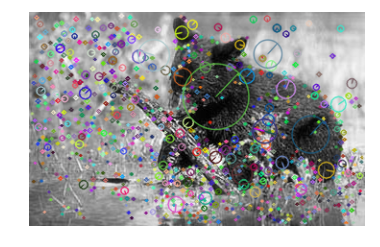

1127
128


In [5]:
# First let us compute the SIFT features using the Python binding for the OpenCV 
# library locally in this notebook to ensure our images have been stored properly
sql = """
        SELECT
            img_name,
            img
        FROM
            cbirapp.training_images
        WHERE img_name like '%Images/CBIR/Caltech256/256_ObjectCategories/009.bear/009_0049.jpg%'
        LIMIT 1;        
"""

df = psql.read_sql(sql,conn)

imgname = np.array(df.loc[0]['img_name'])

img = df.loc[0]['img']
buf = img.split(',')
buf = map(int, buf)
buf = array('b',buf)
buf = buf.tostring()

img_arr = np.asarray(bytearray(buf), dtype=np.uint8)
im = cv2.imdecode(img_arr,-1)
gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT()
kp = sift.detect(gray,None)
sift_img=cv2.drawKeypoints(gray,kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_img)
plt.axis('off')
plt.show()
kp, des = sift.detectAndCompute(gray,None)
feature_vectors = des.flatten().tolist()
print des.shape[0]
print des.shape[1]

#### PLC SIFT Descriptor Computation

We will make use of a PL/C UDF to compute the SIFT descriptors in-database using the C++ OpenCV implementation.

The PLC code is shown below. To compile this code, copy this into a .cpp file located in your home directory on the Greenplum master node (mdw), e.g., SIFTPLC.cpp, and run the following command on the Greenplum master node:

```g++ -shared -Wl,-soname,canny_plc -fPIC -I/usr/local/greenplum-db/include/postgresql/server/ -I/usr/local/greenplum-db/include/postgresql/internal -I/usr/local/greenplum-db/include/ -o sift_plc.so -lopencv_core -lopencv_nonfree SIFTPLC.cpp```

For the code to compile and execute on the Greenplum segments, OpenCV has to be compiled on the Greenplum master node and all the shared objects should be copied over to ```$GPHOME/lib```, where ```$GPHOME``` happens to be /usr/local/greenplum-db/ in our case. This can be achieved via the gpscp command as follows: 

```gpscp -f hostfile mdw-home-directory/sift_plc.so =:/usr/local/greenplum-db/lib```

Important: ```$GPHOME/lib``` should be part of the ```$LD_LIBRARY_PATH``` on the master and all the segment nodes. If not, add ```$GPHOME/lib``` to the ```$LD_LIBRARY_PATH``` and restart Greenplum using the command gpstop -r 

```
/**
* Gautam Muralidhar,Srivatsan Ramanujam DEC 2015
* PL/C function for invoking SIFT DESCRIPTOR from OpenCV
**/

#include <iostream>
#include <string>
#include <vector>
#include "opencv2/opencv.hpp"
#include "opencv2/nonfree/nonfree.hpp"
#include <stdint.h>
using namespace std;

void Tokenize(
    const string& str,
    vector<string>& tokens,
    const string& delimiters = " ") {
    // Skip delimiters at beginning.
    string::size_type lastPos = str.find_first_not_of(delimiters, 0);
    // Find first "non-delimiter".
    string::size_type pos  = str.find_first_of(delimiters, lastPos);

    while (string::npos != pos || string::npos != lastPos)
    {
        // Found a token, add it to the vector.
        tokens.push_back(str.substr(lastPos, pos - lastPos));
        // Skip delimiters.  Note the "not_of"
        lastPos = str.find_first_not_of(delimiters, pos);
        // Find next "non-delimiter"
        pos = str.find_first_of(delimiters, lastPos);
    }
}

uint* siftExtractionFromByteStream(vector<int8_t> src){
    cv::Mat srcImg, srcGray, descriptors, mask;
    cv::vector<cv::KeyPoint> key_points;
    srcImg = cv::imdecode(src, CV_LOAD_IMAGE_COLOR);
    if(srcImg.data ) {
        /// Convert the image to grayscale
        cv::cvtColor(srcImg, srcGray, cv::COLOR_BGR2GRAY);
        /// Call SIFT DESCRIPTOR
        cv::SIFT sift(2000);   //max number of keypoints to retain
        sift(srcGray,mask,key_points,descriptors);
        uint* desc = new uint[(descriptors.rows*descriptors.cols)+1];
        desc[0] = descriptors.rows*descriptors.cols;
        for (int i = 0; i < descriptors.rows; i++) {
            for (int j = 0; j < descriptors.cols; j++) {
                 desc[((descriptors.cols)*i+j)+1] = descriptors.at<float>(i, j);
            }
        }
        return desc;
    } else {
        uint* desc = new uint[1];
        desc[0] = 0;
        return desc;
    }
}

extern "C" {

    #include <postgres.h>
    #include <fmgr.h>
    #include <utils/array.h>
    #include <utils/builtins.h>
    #include <catalog/pg_type.h>
    #include <string>
    #include <vector>
    #include <stdlib.h>
    #include <stdint.h>

    #ifdef PG_MODULE_MAGIC
    PG_MODULE_MAGIC;
    #endif

    // Postgres interface for siftExtractionFromByteStream
    PG_FUNCTION_INFO_V1(sift_plc);
    Datum sift_plc(PG_FUNCTION_ARGS){
        if (PG_ARGISNULL(0)){
             ereport(ERROR, (errmsg("Null arrays not accepted")));
        }
        // Collect the input image byte stream as C string
        char* cstr = TextDatumGetCString(PG_GETARG_DATUM(0));
        string str(cstr);
        vector<string> tokens;
        // Tokenize the string on “,” and collect the tokens, 
        // which represent individual bytes of the image
        Tokenize(str, tokens, ",");
        vector<int8_t> src;
        for (int i = 0; i < tokens.size(); i++) {
            const char* tk = tokens[i].c_str();
            int bt = atoi(tk);
            src.push_back(bt);
        }
        // Call the internal siftExtractionFromByteStream function
        uint* desc = siftExtractionFromByteStream(src);
        // Construct the array to be returned back to the database client
        Datum* resArray = (Datum*)palloc(sizeof(Datum) * desc[0]);
        for (int i = 0; i < desc[0]; i++) {
            resArray[i] = desc[i+1];
        }
        ArrayType *res = construct_array(resArray,
            desc[0], INT4OID, 4, true, 'i');
        PG_RETURN_ARRAYTYPE_P(res);
    }
}
```

In [6]:
# We will first create the UDF
sql = """drop function if exists cbirapp.SiftPLC(varchar) cascade;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create or replace function cbirapp.SiftPLC(varchar) 
    returns int[]
    as 
        '/usr/local/greenplum-db/lib/sift_plc.so', 'sift_plc'
    language C strict immutable;
"""
psql.execute(sql,conn)
conn.commit()

In [8]:
# Let us run the PLC UDF on one image and see if it works
sql = """
   select
       img_name,
       cbirapp.SiftPLC(img) as sift_descriptors
   from
        cbirapp.training_images
    where
        img_name like '%Images/CBIR/Caltech256/256_ObjectCategories/009.bear/009_0049.jpg%'
    limit 1
"""
df = psql.read_sql(sql,conn)
imgname = np.array(df.loc[0]['img_name'])
sift_descriptors = df.loc[0]['sift_descriptors']
print sift_descriptors

[52, 106, 58, 8, 0, 0, 0, 0, 166, 166, 2, 0, 1, 0, 0, 0, 35, 25, 6, 4, 6, 10, 0, 0, 0, 0, 3, 10, 6, 21, 2, 0, 112, 41, 14, 2, 0, 0, 0, 17, 166, 77, 0, 0, 0, 0, 0, 17, 103, 25, 4, 1, 0, 2, 1, 12, 4, 1, 0, 0, 1, 25, 8, 5, 116, 2, 0, 0, 0, 0, 2, 97, 166, 6, 0, 0, 0, 0, 0, 114, 93, 39, 7, 1, 1, 0, 0, 14, 6, 18, 11, 1, 2, 5, 1, 1, 122, 2, 0, 0, 0, 0, 0, 57, 166, 9, 0, 1, 4, 0, 0, 46, 33, 24, 10, 11, 18, 0, 0, 6, 10, 39, 11, 1, 0, 0, 0, 0, 129, 3, 0, 0, 0, 0, 0, 59, 164, 9, 0, 0, 1, 0, 0, 45, 54, 9, 5, 15, 25, 0, 0, 9, 13, 42, 9, 3, 2, 0, 0, 0, 132, 10, 0, 0, 0, 0, 0, 44, 164, 24, 0, 0, 3, 3, 1, 34, 64, 5, 1, 9, 63, 27, 1, 14, 18, 30, 4, 2, 7, 3, 0, 2, 146, 21, 0, 0, 0, 0, 0, 28, 164, 35, 0, 0, 3, 1, 0, 27, 79, 16, 0, 1, 59, 49, 4, 6, 3, 4, 3, 1, 10, 25, 4, 2, 87, 103, 3, 0, 0, 0, 0, 1, 164, 126, 0, 0, 0, 0, 0, 3, 111, 45, 0, 0, 8, 51, 15, 12, 1, 1, 0, 0, 18, 74, 7, 0, 19, 144, 84, 0, 0, 0, 0, 0, 52, 144, 25, 0, 0, 0, 0, 0, 11, 20, 4, 2, 5, 3, 0, 1, 0, 0, 0, 0, 5, 25, 5, 2, 87, 118, 3, 0, 0,

#### Now let us create a table with the raw SIFT descriptors computed for each training image

In [21]:
sql = """drop table if exists cbirapp.training_sift_descriptors;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.training_sift_descriptors as (
       select
           img_name,
           cbirapp.SiftPLC(img) as sift_descriptors
       from
            cbirapp.training_images
    ) distributed by (img_name);
"""
psql.execute(sql,conn)
conn.commit()

In [22]:
# Now let us run some diagnostics to see if the SIFT descriptors have been computed well
sql = """select count(distinct img_name) from cbirapp.training_sift_descriptors;"""
psql.read_sql(sql,conn) # Should be 907

,count
0,907


In [23]:
sql = """
    select 
        sum(num_keypts)
    from (
        select 
            (array_upper(sift_descriptors,1)/128) as num_keypts
        from 
            cbirapp.training_sift_descriptors
    ) q
"""
psql.read_sql(sql,conn) # should not execeed 907*2000 = 1,814,000

,sum
0,592426


####Now let us create a table with the raw SIFT descriptors computed for each testing image


In [24]:
sql = """drop table if exists cbirapp.testing_sift_descriptors;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.testing_sift_descriptors as (
       select
           img_name,
           cbirapp.SiftPLC(img) as sift_descriptors
       from
            cbirapp.testing_images
    ) distributed by (img_name);
"""
psql.execute(sql,conn)
conn.commit()

In [25]:
# Now let us run some diagnostics to see if the SIFT descriptors have been computed well
sql = """select count(distinct img_name) from cbirapp.testing_sift_descriptors;"""
psql.read_sql(sql,conn) # Should be 113

,count
0,113


In [26]:
sql = """
    select 
        sum(num_keypts)
    from (
        select 
            (array_upper(sift_descriptors,1)/128) as num_keypts
        from 
            cbirapp.testing_sift_descriptors
    ) q
"""
psql.read_sql(sql,conn) # should not exceed 2000*113 = 226,000

,sum
0,79326


####We will now create  Root SIFT Descriptors that has shown to improve object recogntion. 
####For details, see https://www.robots.ox.ac.uk/~vgg/publications/2012/Arandjelovic12/arandjelovic12.pdf 

In [31]:
# First let us create the PL/Python UDF
sql = """
    create or replace function cbirapp.compute_root_sift(sift_descriptors int[]) 
    returns SETOF float[]
    AS
    $$
        import numpy as np
        eps = 1e-7
        descs = np.reshape(sift_descriptors, (len(sift_descriptors)/128, 128))
        descs = descs*1.0 / (descs.sum(axis=1)[:,np.newaxis] + eps)
        descs = np.sqrt(descs)
        return descs
    $$ language plpythonu;
"""
psql.execute(sql,conn)
conn.commit()

In [32]:
# Compute the training root SIFT descriptors
sql = """drop table if exists cbirapp.training_root_sift_descriptors;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.training_root_sift_descriptors as (
       select
           img_name,
            cbirapp.compute_root_sift(sift_descriptors) as root_sift_descriptors
       from
            cbirapp.training_sift_descriptors
    ) distributed by (img_name);
"""
psql.execute(sql,conn)
conn.commit()

In [33]:
# Let us run some diagnostics on the training root SIFT descriptors
sql = """select count(*) from cbirapp.training_root_sift_descriptors;"""
psql.read_sql(sql,conn) # should be 592426 (see above)

,count
0,592426


In [34]:
sql = """select count(distinct img_name) from cbirapp.training_root_sift_descriptors;"""
psql.read_sql(sql,conn) # should be 907

,count
0,907


In [35]:
sql = """
    select 
        array_upper(root_sift_descriptors,1) 
    from 
        cbirapp.training_root_sift_descriptors 
    group by 1;"""
psql.read_sql(sql,conn) # should be 128

,array_upper
0,128


In [36]:
# Compute the testing root SIFT descriptors
sql = """drop table if exists cbirapp.testing_root_sift_descriptors;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.testing_root_sift_descriptors as (
       select
           img_name,
            cbirapp.compute_root_sift(sift_descriptors) as root_sift_descriptors
       from
            cbirapp.testing_sift_descriptors
    ) distributed by (img_name);
"""
psql.execute(sql,conn)
conn.commit()

In [37]:
# Let us run some diagnostics on the testing root SIFT descriptors
sql = """select count(*) from cbirapp.testing_root_sift_descriptors;"""
psql.read_sql(sql,conn) # should be 79326 (see above)

,count
0,79326


In [38]:
sql = """select count(distinct img_name) from cbirapp.testing_root_sift_descriptors;"""
psql.read_sql(sql,conn) # should be 113

,count
0,113


In [39]:
sql = """
    select 
        array_upper(root_sift_descriptors,1) 
    from 
        cbirapp.testing_root_sift_descriptors 
    group by 1;"""
psql.read_sql(sql,conn) # should be 128

,array_upper
0,128


#### We will now create the vocabulary by performing a k-means clustering of the training root SIFT descriptors
#### I recommend this step to be run in a unix screen as it could take a while to complete

In [ ]:
sql = """
    create table cbirapp.training_root_sift_centroids as (
        select 
            centroids as mean_root_sift_vectors,
            num_iterations
        from 
            madlib.kmeans_random( 
                'cbirapp.training_root_sift_descriptors',
                'root_sift_descriptors',
                5000,
                'madlib.squared_dist_norm2',
                'madlib.avg',
                100,
                0.001
            )
    ) distributed by (mean_root_sift_vectors); 
"""
psql.execute(sql,conn)
conn.commit()

In [ ]:
# Now assign each Root SIFT Descriptor to one of the 5000 visual words
sql = """
    create table cbirapp.training_root_sift_cluster_assignment as 
    (
        select 
            data.*, 
            (madlib.closest_column(
                q.mean_root_sift_vectors, 
                data.root_sift_descriptors
            )).column_id as cluster_id
        from 
            cbirapp.training_root_sift_descriptors as data,
            (
            select 
                mean_root_sift_vectors
            from  
                cbirapp.training_root_sift_centroids
            ) q
    )distributed by(root_sift_descriptors);
"""
psql.execute(sql,conn)
conn.commit()

In [44]:
# We will now build a visual word histogram (bag-of-words representation) for each 
# training image
sql = """drop table if exists cbirapp.training_root_sift_word_hist_table;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.training_root_sift_word_hist_table as
    (
        select
            img_name, 
            (dense_rank() over (order by img_name)-1)::INT4 as docid, 
            cluster_id::INT4 as wordid, 
            count(cluster_id)::INT4 as count 
        from 
            cbirapp.training_root_sift_cluster_assignment
        group by (cluster_id, img_name) 
        order by docid, wordid
) distributed BY(docid);
"""
psql.execute(sql,conn)
conn.commit()

#### We will now call the MADlib LDA training function to estimate the latent topics

In [ ]:
sql = """drop table if exists cbirapp.trained_root_sift_lda_model;"""
psql.execute(sql,conn)
conn.commit()

sql = """drop table if exists cbirapp.trained_root_sift_lda_out_data;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    select
        madlib.lda_train( 
            'cbirapp.training_root_sift_word_hist_table',  
            'cbirapp.trained_root_sift_lda_model', 
            'cbirapp.trained_root_sift_lda_out_data', 
            5000,
            50,
            100,
            0.1,
            0.001
       );
"""
psql.execute(sql,conn)
conn.commit()

In [50]:
# Now compute the topic distributions per image
sql = """drop table if exists cbirapp.training_root_sift_topic_proportions;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.training_root_sift_topic_proportions as 
    (
        select distinct 
            hist_table.img_name, 
            lda_out.docid,  
            lda_out.topic_count, 
            madlib.array_scalar_mult(
                lda_out.topic_count::float8[], 
                1/(madlib.array_sum(lda_out.topic_count)::float8)
            ) as topic_proportions
        from
            cbirapp.trained_root_sift_lda_out_data lda_out, 
            cbirapp.training_root_sift_word_hist_table as hist_table
        where 
            hist_table.docid = lda_out.docid
    ) distributed by(docid);
"""
psql.execute(sql,conn)
conn.commit()

#### Now we will see how well our models perform in retrieving similar images for a query image in the test set

In [45]:
# First let us assign the Root SIFT descriptors in each test image to a visual word
# Now assign each Root SIFT Descriptor to one of the 5000 visual words
sql = """
    create table cbirapp.testing_root_sift_cluster_assignment as 
    (
        select 
            data.*, 
            (madlib.closest_column(
                q.mean_root_sift_vectors, 
                data.root_sift_descriptors
            )).column_id as cluster_id
        from 
            cbirapp.testing_root_sift_descriptors as data,
            (
            select 
                mean_root_sift_vectors
            from  
                cbirapp.training_root_sift_centroids
            ) q
    )distributed by(root_sift_descriptors);
"""
psql.execute(sql,conn)
conn.commit()

In [46]:
# Now let us represent each test image by a visual word histogram
sql = """drop table if exists cbirapp.testing_root_sift_word_hist_table;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.testing_root_sift_word_hist_table as
    (
        select
            img_name, 
            (dense_rank() over (order by img_name)-1)::INT4 as docid, 
            cluster_id::INT4 as wordid, 
            count(cluster_id)::INT4 as count 
        from 
            cbirapp.testing_root_sift_cluster_assignment
        group by (cluster_id, img_name) 
        order by docid, wordid
) distributed BY(docid);
"""
psql.execute(sql,conn)
conn.commit()

In [47]:
# Now call MADlib lda_predict function to predict the latent topics given the trained LDA model
# and new image data
sql = """drop table if exists cbirapp.predicted_root_sift_lda_out_data;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    select 
        madlib.lda_predict( 
            'cbirapp.testing_root_sift_word_hist_table', 
            'cbirapp.trained_root_sift_lda_model', 
            'cbirapp.predicted_root_sift_lda_out_data'
        );
"""
psql.execute(sql,conn)
conn.commit()

In [54]:
# Now compute the topic distributions per test image
sql = """drop table if exists cbirapp.testing_root_sift_topic_proportions;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.testing_root_sift_topic_proportions as 
    (
        select distinct 
            hist_table.img_name, 
            lda_out.docid,  
            lda_out.topic_count, 
            madlib.array_scalar_mult(
                lda_out.topic_count::float8[], 
                1/(madlib.array_sum(lda_out.topic_count)::float8)
            ) as topic_proportions
        from
            cbirapp.predicted_root_sift_lda_out_data lda_out, 
            cbirapp.testing_root_sift_word_hist_table as hist_table
        where 
            hist_table.docid = lda_out.docid
    ) distributed by(docid);
"""
psql.execute(sql,conn)
conn.commit()

#### We will now run a simple k-nearest neighbor image retriever

In [57]:
sql = """drop table if exists cbirapp.root_sift_knn_retrieval;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.root_sift_knn_retrieval as
    (
        select
            lda_test.docid as test_docid, 
            lda_test.img_name as test_img_name, 
            substring(substring(lda_test.img_name from 45) from 1 for 
                position('/' in substring(lda_test.img_name from 45))-1) 
                    as test_category_name, 
            lda_train.docid as train_docid, 
            lda_train.img_name as train_img_name, 
            substring(substring(lda_train.img_name from 45) from 1 for 
                position('/' in substring(lda_train.img_name from 45))-1) 
                    as train_category_name, 
            lda_test.topic_proportions as test_topic_vectors, 
            lda_train.topic_proportions as train_topic_vectors,  
            madlib.array_dot(
                lda_test.topic_proportions, 
                lda_train.topic_proportions
            )/(
                madlib.norm2(lda_test.topic_proportions)*
                madlib.norm2(lda_train.topic_proportions)
            ) as cosine_similarity
        from
            cbirapp.testing_root_sift_topic_proportions as lda_test, 
            cbirapp.training_root_sift_topic_proportions as lda_train
    ) distributed by(test_docid);
"""
psql.execute(sql,conn)
conn.commit()

In [66]:
sql = """drop table if exists cbirapp.top_k_retrieved_images;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.top_k_retrieved_images as (
        select
            test_img_name,  
            test_category_name,
            train_img_name,
            train_category_name,
            cosine_similarity,
            test_train_category_equal
        from (
            select
                ROW_NUMBER() over ( 
                    partition by test_img_name order by cosine_similarity DESC
                ) AS RowNumber,
                test_img_name,
                test_category_name,
                train_img_name,
                train_category_name,
                cosine_similarity,
                test_category_name = train_category_name as test_train_category_equal        
            from
                cbirapp.root_sift_knn_retrieval
        ) inner_query
        where RowNumber <= 9
    )distributed by(test_img_name);
"""
psql.execute(sql,conn)
conn.commit()

In [67]:
# Let us now compute the precision per test category
sql = """drop table if exists cbirapp.top_k_retrieval_root_sift_precision;"""
psql.execute(sql,conn)
conn.commit()

sql = """
    create table cbirapp.top_k_retrieval_root_sift_precision as (
        select
            test_img_name,
            test_category_name,
            tcount,
            fcount,
            allcount,
            tcount::float/allcount::float as precision
        from
        (   
            select
                test_img_name, 
                test_category_name,
                count(*) filter(where test_train_category_equal = 't')  tcount, 
                count(*) filter(where test_train_category_equal <> 't') fcount,
                count(*) allcount
            from
                cbirapp.top_k_retrieved_images
            group by 1,2 
            order by test_img_name
         ) inner_query
    ) distributed by (test_img_name);
"""
psql.execute(sql,conn)
conn.commit()

sql = """
    select
        test_category_name,
        all_true_count,
        all_img_count,
        all_true_count::float8/all_img_count::float8 as test_category_precision
    from
    (
        select 
            test_category_name,
            sum(tcount) as all_true_count,
            sum(allcount) as all_img_count
        from 
            cbirapp.top_k_retrieval_root_sift_precision
        group by 1
    ) inner_query
    order by test_category_precision desc;
"""
psql.read_sql(sql,conn)

,test_category_name,all_true_count,all_img_count,test_category_precision
0,082.galaxy,68,72,0.944444
1,090.gorilla,134,189,0.708995
2,232.t-shirt,195,324,0.601852
3,072.fire-truck,63,108,0.583333
4,218.tennis-racket,42,72,0.583333
5,213.teddy-bear,40,90,0.444444
6,009.bear,29,90,0.322222
7,086.golden-gate-bridge,22,72,0.305556


In [68]:
# Close DB connection
conn.close()